In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

In [18]:
df = pd.read_csv('./dataset/processed_dataset.csv')

In [19]:
# Split the data into training and testing sets
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=7)),  
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),  
    ('gb', GradientBoostingClassifier(random_state=42))
])

In [21]:
param_dist = {
    'gb__n_estimators': [100, 200],  
    'gb__learning_rate': [0.1, 0.3],
    'gb__max_depth': [3, 4],  
    'gb__min_samples_split': [5],  
    'gb__subsample': [0.8],  
}

In [22]:
# Perform GridSearch
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=4,  # Số lượng combinations được thử
    cv=3,  # Giảm số fold trong cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit model
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('feature_selection',
                                              SelectKBest(k=7)),
                                             ('smote',
                                              SMOTE(random_state=42,
                                                    sampling_strategy=0.5)),
                                             ('gb',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=4, n_jobs=-1,
                   param_distributions={'gb__learning_rate': [0.1, 0.3],
                                        'gb__max_depth': [3, 4],
                                        'gb__min_samples_split': [5],
                                        'gb__n_estimators': [100, 200],
                                        'gb__subsample': [0.8]},
                   scoring='f1', verbose=1)

In [23]:
# Get best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1]

In [24]:
# Print model evaluation
print("\nBest Parameters:", random_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'gb__subsample': 0.8, 'gb__n_estimators': 100, 'gb__min_samples_split': 5, 'gb__max_depth': 4, 'gb__learning_rate': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     26267
           1       0.95      0.71      0.81      2577

    accuracy                           0.97     28844
   macro avg       0.96      0.85      0.90     28844
weighted avg       0.97      0.97      0.97     28844



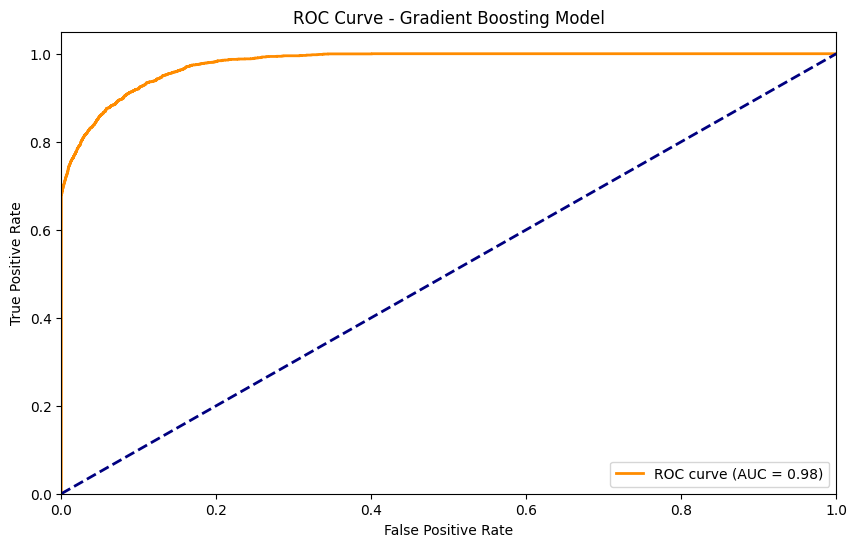

In [25]:
# Plot ROC Curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Model')
plt.legend(loc="lower right")
plt.show()

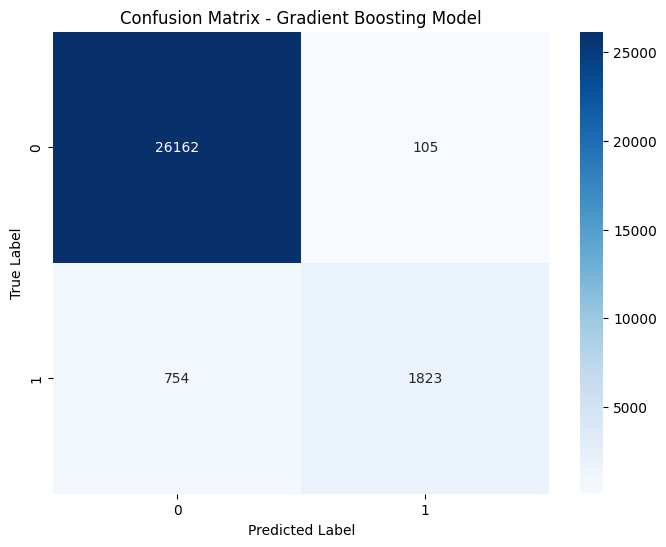

In [26]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

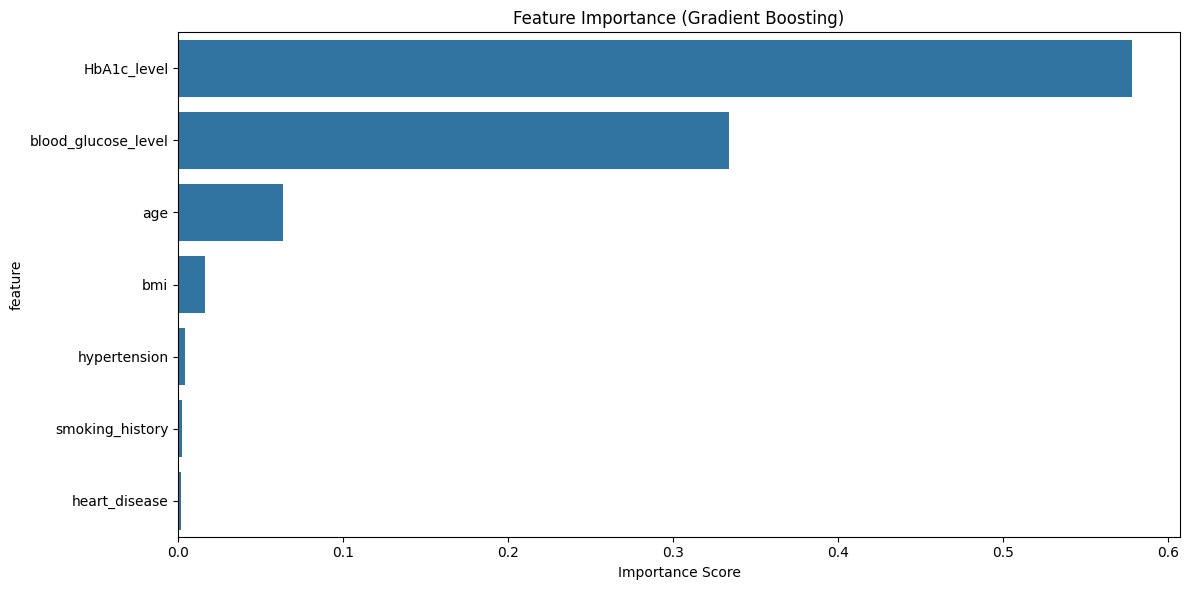

In [27]:
# Feature Importance
feature_selector = best_model.named_steps['feature_selection']
selected_features_mask = feature_selector.get_support()
selected_features = X.columns[selected_features_mask].tolist()

feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': best_model.named_steps['gb'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Gradient Boosting)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

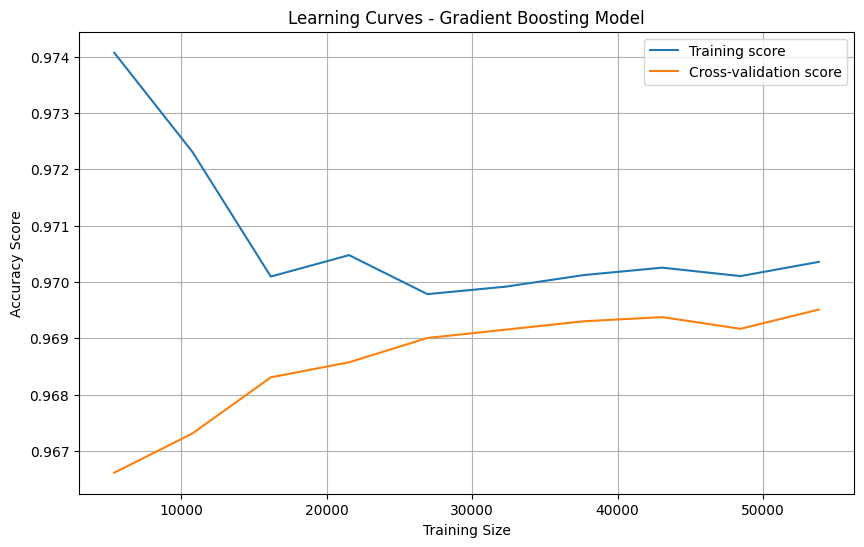

In [28]:
# Learning Curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves - Gradient Boosting Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()

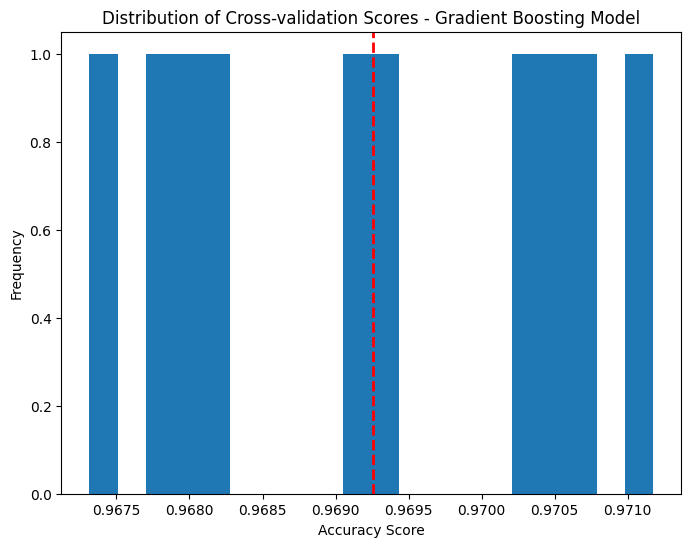


Cross-validation Scores Summary:
Mean Accuracy: 0.969 (+/- 0.003)


In [29]:
# Cross-validation Scores Distribution
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=10, scoring='accuracy')

plt.figure(figsize=(8, 6))
plt.hist(cv_scores, bins=20)
plt.axvline(cv_scores.mean(), color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cross-validation Scores - Gradient Boosting Model')
plt.show()

print("\nCross-validation Scores Summary:")
print(f"Mean Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")